# Compose: Training a model to generate music

In [1]:
import os
import pickle
import numpy
import pydot
from matplotlib import pyplot
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, prepare_sequences_with_velocity, create_network_with_velocity

Using TensorFlow backend.


## Set parameters

In [2]:
# run params
section = 'compose'
run_id = 'RNN_add_velocity'
genre_name = 'classical'
composer_name='bach2'

run_folder = 'run/{}/{}/'.format(section, genre_name)
run_folder += '_'.join([run_id, composer_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', genre_name, composer_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'load' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True
reg = None
learning_rate = 0.001

## Extract the notes

In [3]:
data_folder

'data/classical/bach2'

In [5]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []
    velocities = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            #notes.extend(['START'] * seq_len)
            #durations.extend([0]* seq_len)
            #velocities.extend([0]* seq_len)
            notes.extend(['START'])
            durations.extend([0])
            velocities.extend([0])

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                        velocities.append(element.volume.velocity)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)
                        velocities.append(element.volume.velocity)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)
                    velocities.append(element.volume.velocity)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f) 
    with open(os.path.join(store_folder, 'velocities'), 'wb') as f:
        pickle.dump(velocities, f) 
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 
    with open(os.path.join(store_folder, 'velocities'), 'rb') as f:
        velocities = pickle.load(f) 

## Create the lookup tables

In [6]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
velocity_names, n_velocities = get_distinct(velocities)
distincts = [note_names, n_notes, duration_names, n_durations, velocity_names, n_velocities]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
velocity_to_int, int_to_velocity = create_lookups(velocity_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration, velocity_to_int, int_to_velocity]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [7]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A3': 0,
 'A3.A4': 1,
 'A3.A4.C#5': 2,
 'A3.A4.C#5.E5': 3,
 'A3.A4.C#5.F5.G5': 4,
 'A3.A4.C5': 5,
 'A3.A4.C5.A5': 6,
 'A3.A4.C5.B5': 7,
 'A3.A4.C5.C6': 8,
 'A3.A4.C5.E5': 9,
 'A3.A4.C5.F#5': 10,
 'A3.A4.C5.F5': 11,
 'A3.A4.C5.G5': 12,
 'A3.A4.D5': 13,
 'A3.A4.D5.E5': 14,
 'A3.A4.D5.F5': 15,
 'A3.A4.E5': 16,
 'A3.A4.F5': 17,
 'A3.B-3.F4.D5': 18,
 'A3.B-3.F4.E-5': 19,
 'A3.B-3.G4.A4.D5.E5': 20,
 'A3.B3': 21,
 'A3.B3.C4.D4': 22,
 'A3.C#5': 23,
 'A3.D4': 24,
 'A3.D4.A4.C5.F5': 25,
 'A3.D4.B4': 26,
 'A3.D4.B4.F#5': 27,
 'A3.D4.C5.F#5': 28,
 'A3.D4.E4.A4.C#5.F5.G5': 29,
 'A3.D4.E4.F4.A4.C#5.F5': 30,
 'A3.D4.F4.D5': 31,
 'A3.D5': 32,
 'A3.E-4': 33,
 'A3.E-4.C5': 34,
 'A3.E4': 35,
 'A3.E4.A4': 36,
 'A3.E4.A4.C#5.D5.E5.A5': 37,
 'A3.E4.A4.G5': 38,
 'A3.E4.B4': 39,
 'A3.E4.B4.C5.D5': 40,
 'A3.E4.C#5': 41,
 'A3.E4.C#5.A5': 42,
 'A3.E4.C#5.A5.B-5': 43,
 'A3.E4.C#5.B-5': 44,
 'A3.E4.C#5.B5': 45,
 'A3.E4.C#5.E5': 46,
 'A3.E4.C#5.F5': 47,
 'A3.E4.C#5.G5': 48,
 'A3.E4.C#5.G5.A5': 49,
 'A3.E4.C5': 50,

In [8]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(2, 3): 7,
 0.75: 8,
 1.0: 9,
 Fraction(7, 6): 10,
 1.25: 11,
 Fraction(4, 3): 12,
 1.5: 13,
 1.75: 14,
 2.0: 15,
 2.5: 16,
 2.75: 17,
 3.0: 18,
 Fraction(11, 3): 19,
 4.0: 20}

## Prepare the sequences used by the Neural Network

In [9]:
network_input, network_output = prepare_sequences_with_velocity(notes, durations, velocities, lookups, distincts, seq_len)

In [10]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('velocity input')
print(network_input[2][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])
print('velocity output')
print(network_output[2][0])

pitch input
[1133  280  746  128  127  561  772  630  387 1086 1110  741  726  878
  865  798 1065  792  707  589  366  302  271  302   94  102  188  286
  278 1110 1099 1094]
duration input
[ 0  9  9  6  6 13  6  6  6  6  6  6  6  6  6 13  6  6  6  9  9  3  3  6
 13  6  9  6  6  6  6  6]
velocity input
[ 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15]
pitch output
[0. 0. 0. ... 0. 0. 0.]
duration output
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
velocity output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


## Create the structure of the neural network

In [11]:
model, att_model = create_network_with_velocity(n_notes, n_durations, n_velocities, embed_size, rnn_units, use_attention, reg, learning_rate)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    113400      input_1[0][0]                    
____________________________________________________________________________________________

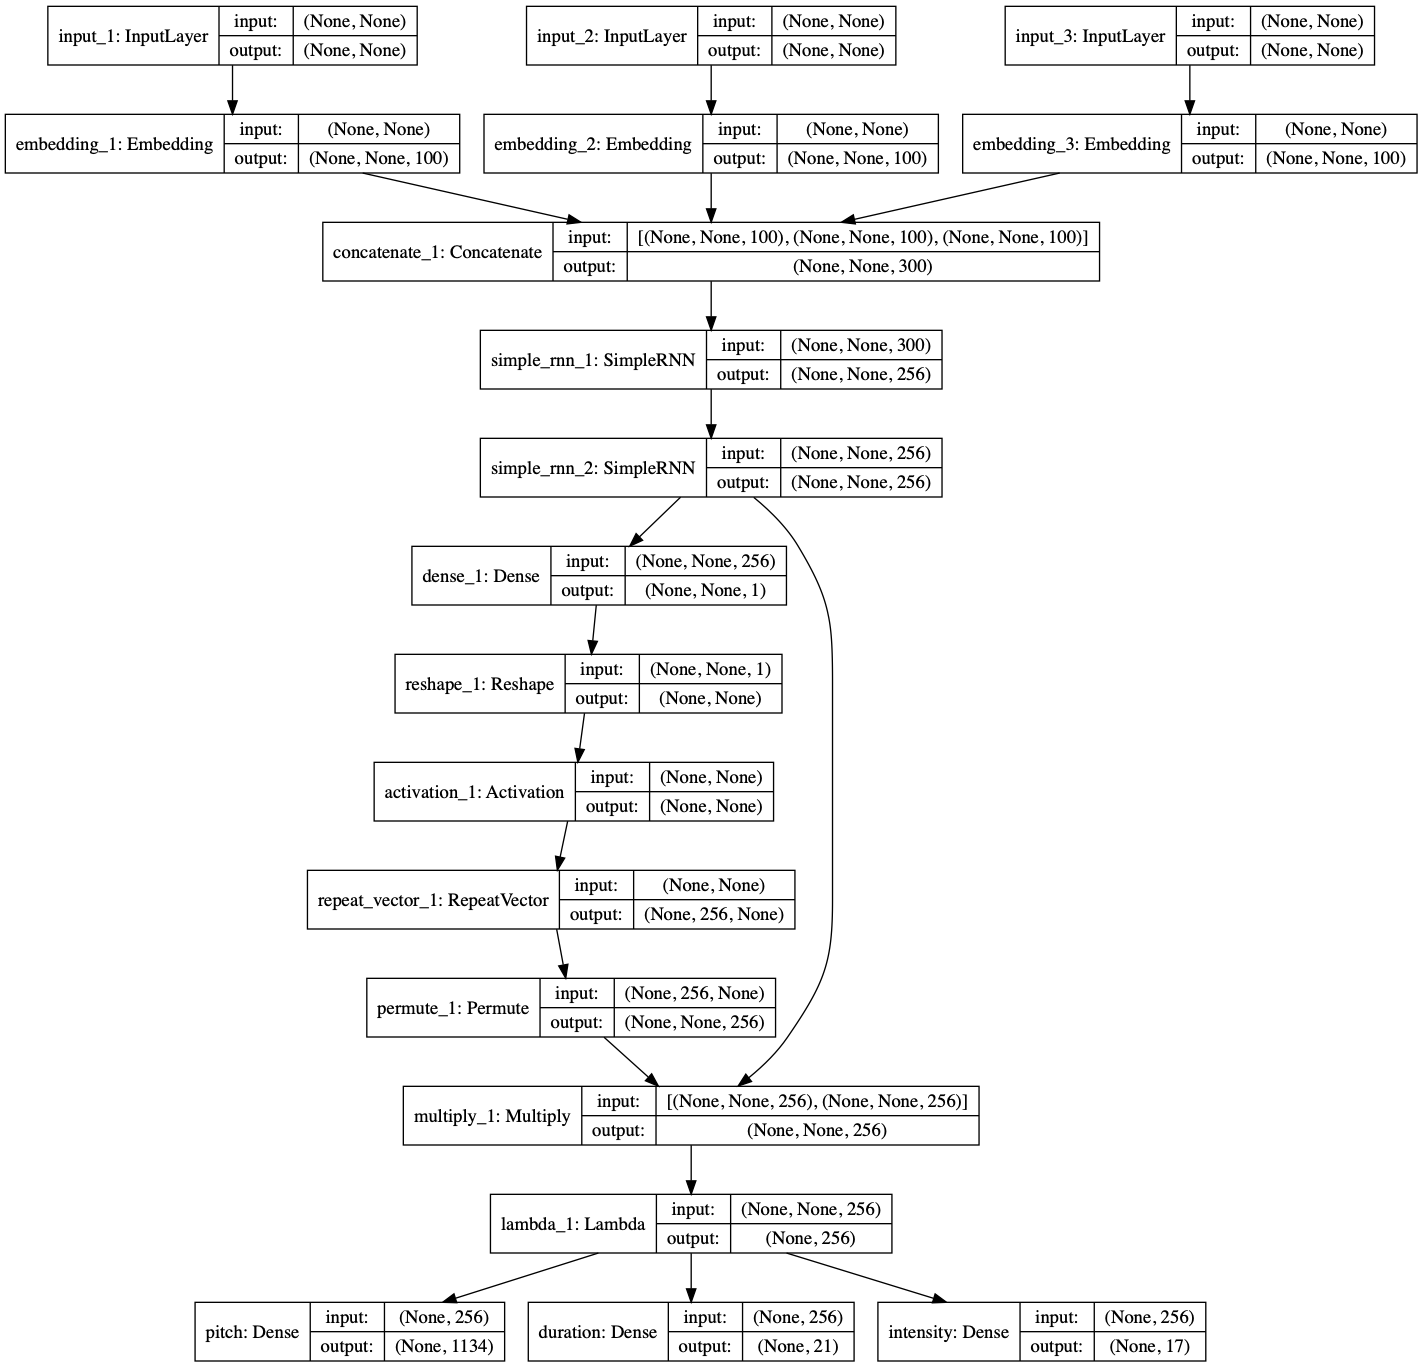

In [12]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

## Train the neural network

In [13]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [14]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
history = model.fit(network_input, network_output
          , epochs=1000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

train_history = history.history['loss']
val_history = history.history['val_loss']




/Users/weiliang/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25564 samples, validate on 6392 samples
Epoch 1/1000
25564/25564 [==============================] - 60s 2ms/step - loss: 5.3891 - pitch_loss: 4.4353 - duration_loss: 0.7733 - intensity_loss: 0.1805 - val_loss: 4.0068 - val_pitch_loss: 3.4984 - val_duration_loss: 0.3684 - val_intensity_loss: 0.1404
Epoch 2/1000
25564/25564 [==============================] - 57s 2ms/step - loss: 4.9641 - pitch_loss: 4.2076 - duration_loss: 0.6350 - intensity_loss: 0.1216 - val_loss: 3.9663 - val_pitch_loss: 3.4922 - val_duration_loss: 0.3486 - val_intensity_loss: 0.1261
Epoch 3/1000
25564/25564 [==============================] - 54s 2ms/step - loss: 4.8764 - pitch_loss: 4.1562 - duration_loss: 0.6148 - intensity_loss: 0.1054 - val_loss: 3.8652 - val_pitch_loss: 3.4122 - val_duration_loss: 0.3652 - val_intensity_loss: 0.0882
Epoch 4/1000
25564/25564 [==============================] - 55s 2ms/step - loss: 4.7845 - pitch_loss: 4.1050 - duration_loss: 0.5868 - intensity_loss: 0.0927 - val_loss: 3.87

25564/25564 [==============================] - 74s 3ms/step - loss: 4.5219 - pitch_loss: 4.0353 - duration_loss: 0.4351 - intensity_loss: 0.0514 - val_loss: 3.5989 - val_pitch_loss: 3.2100 - val_duration_loss: 0.3365 - val_intensity_loss: 0.0532
Epoch 33/1000
25564/25564 [==============================] - 74s 3ms/step - loss: 4.4660 - pitch_loss: 3.9982 - duration_loss: 0.4180 - intensity_loss: 0.0495 - val_loss: 3.5958 - val_pitch_loss: 3.2136 - val_duration_loss: 0.3310 - val_intensity_loss: 0.0519
Epoch 34/1000
25564/25564 [==============================] - 80s 3ms/step - loss: 4.4347 - pitch_loss: 3.9758 - duration_loss: 0.4098 - intensity_loss: 0.0491 - val_loss: 3.5852 - val_pitch_loss: 3.2046 - val_duration_loss: 0.3299 - val_intensity_loss: 0.0516


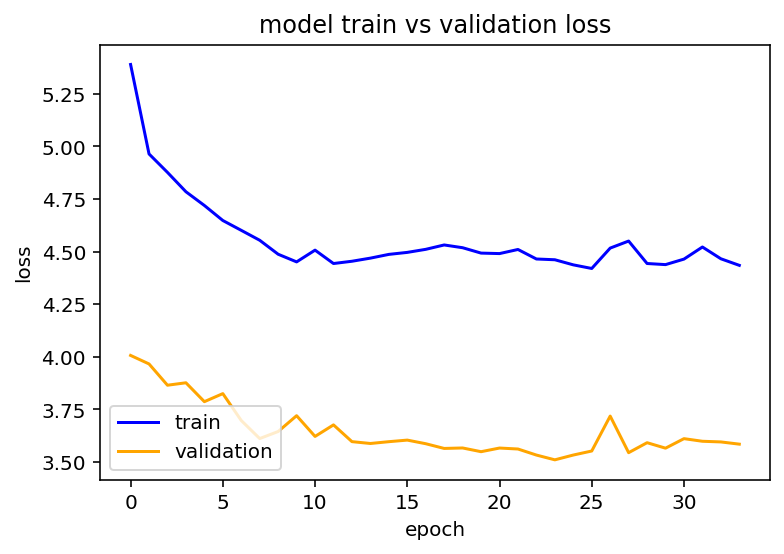

In [15]:
pyplot.plot(train_history, color='blue', label='train')
pyplot.plot(val_history, color='orange', label='validation')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower left')
pyplot.show()